In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [5]:
measurement = Base.classes.measurement
station = Base.classes.station

In [6]:
session=Session(engine)

# Investigate the Database

In [7]:
from sqlalchemy import inspect
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    primarykeystr = ""
    if c['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(c["name"],c["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    primarykeystr = ""
    if c['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(c["name"], c["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [10]:
recdate = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recdate[0])

2017-08-23


In [11]:
recdate1 = dt.datetime.strptime(recdate[0], '%Y-%m-%d')
yeardate = dt.date(recdate1.year -1, recdate1.month, recdate1.day)
print(yeardate)

2016-08-23


In [12]:
prec= [measurement.date,measurement.prcp]
yeardateprec = session.query(*prec).filter(measurement.date >= yeardate).all()
precdf = (pd.DataFrame(yeardateprec, columns=['Date','Precipitation']).sort_values(["Date"], ascending=True)).dropna()
precdf

Date  Precipitation
0     2016-08-23           0.00
1529  2016-08-23           1.79
704   2016-08-23           0.05
361   2016-08-23           0.15
1881  2016-08-23           0.70
...          ...            ...
1527  2017-08-22           0.00
1008  2017-08-23           0.00
360   2017-08-23           0.00
1528  2017-08-23           0.08
2229  2017-08-23           0.45

[2021 rows x 2 columns]

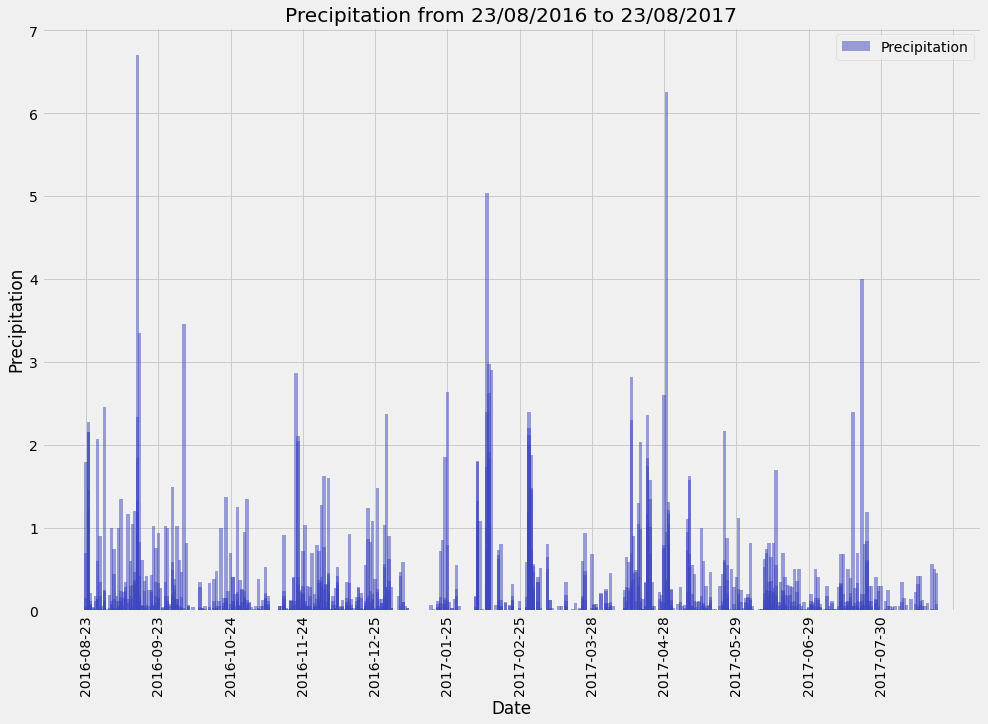

In [13]:
ax,plot=plt.subplots (figsize=(15, 10))
plt.bar(precdf["Date"],precdf["Precipitation"], color = '#3d46bf',alpha=0.5,label='Precipitation',width=1.5)
plt.xticks(np.arange(0,400,31),rotation=90)  
plt.legend ()
plt.title("Precipitation from 23/08/2016 to 23/08/2017")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid( linestyle='-')
plt.show()

In [14]:
precdf.describe ()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Station Analysis

In [15]:
session.query(station.id).count()

9

In [16]:
#most active= most records?
query= session.query(measurement.station, measurement.date).all()
stats_df = pd.DataFrame(query, columns=['station', 'count'])
stats_df = stats_df.groupby(['station']).count().sort_values('count', ascending=False )
stats_df


count
station           
USC00519281   2772
USC00519397   2724
USC00513117   2709
USC00519523   2669
USC00516128   2612
USC00514830   2202
USC00511918   1979
USC00517948   1372
USC00518838    511

In [17]:
select = [measurement.station,func.count(measurement.id)]
higheststations = session.query(*select).group_by(measurement.station).order_by(func.count(measurement.id).\
                                                                             desc()).all()
higheststations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
#only need station and name column, filter?
high_activity = stats_df.index[0]
highcountdf = pd.DataFrame(session.query(station.station, station.name).filter(station.station == high_activity).all(), columns=["station", "name"])
stationid =  highcountdf.loc[0, "station"]
stationname= highcountdf.loc[0, "name"]
highcountdf
#print(stationid)
#print(stationname)

station                 name
0  USC00519281  WAIHEE 837.5, HI US

In [19]:
high_activity

'USC00519281'

In [20]:
print(stationid)
print(stationname)

USC00519281
WAIHEE 837.5, HI US


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#You’ll need to use functions such as func.min, func.max, and func.avg in your query
temps = session.query(measurement.station, measurement.date, measurement.tobs).filter(measurement.station == high_activity).all()
tempsdf=pd.DataFrame(temps, columns=['ID','Date','TOBS'])
print(tempsdf['TOBS'].min ())
print(tempsdf['TOBS'].max ())
print(round(tempsdf['TOBS'].mean (),2))

54.0
85.0
71.66


In [22]:
tempsdf

ID        Date  TOBS
0     USC00519281  2010-01-01  70.0
1     USC00519281  2010-01-02  62.0
2     USC00519281  2010-01-03  74.0
3     USC00519281  2010-01-04  75.0
4     USC00519281  2010-01-05  74.0
...           ...         ...   ...
2767  USC00519281  2017-08-14  77.0
2768  USC00519281  2017-08-15  77.0
2769  USC00519281  2017-08-16  76.0
2770  USC00519281  2017-08-17  76.0
2771  USC00519281  2017-08-18  79.0

[2772 rows x 3 columns]

In [27]:
queryresulttob = session.query(measurement.tobs).\
    filter(measurement.station == higheststations[0][0]).\
    filter(measurement.date >= yeardate).all()
temps= list(np.ravel(queryresulttob))

In [28]:
#temps

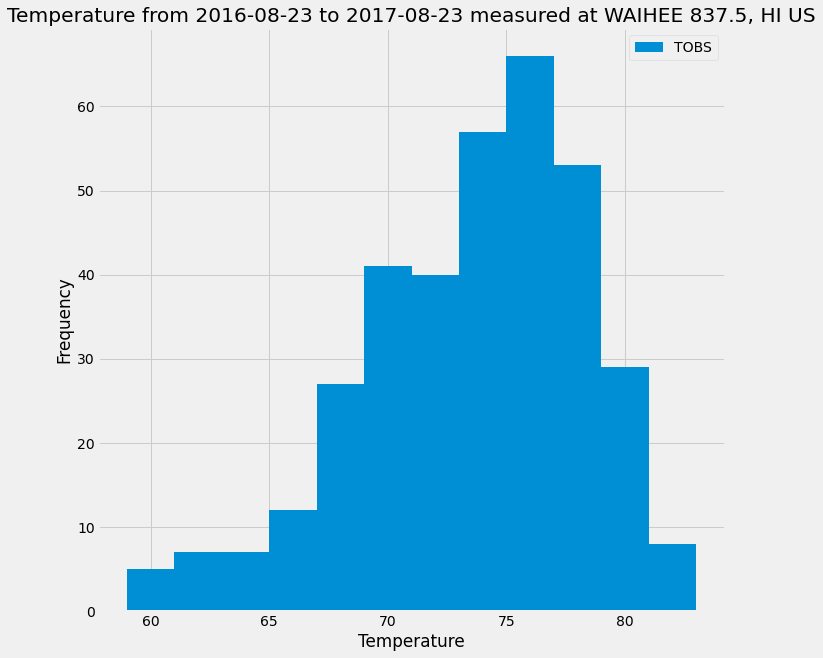

In [29]:
#plotting histogram 
plt.subplots(figsize=(10,10))
plt.hist(temps, bins=12,rwidth=1.0,label='TOBS')
plt.grid(alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f'Temperature from 2016-08-23 to 2017-08-23 measured at {stationname}')
plt.legend()
plt.show ()

In [26]:
session.close()